# Librerías

In [1]:
import numpy as np 
import pandas as pd
import joblib
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color 
import os
from tqdm import tqdm 
from skimage.transform import resize 
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain 
from scipy import stats 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

#Metricas de performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Importar Caras y Fondos

In [2]:
face_suffix = '.pgm'
face_dir = os.listdir('Faces/')
pgm_files = [filename for filename in face_dir if filename.endswith(face_suffix)]

face_suffix = '.png'
fondos_dir = os.listdir('Generar_Fondos/generated_patches/')
png_files = [filename for filename in fondos_dir if filename.endswith(face_suffix)]

positive_patches = []
for filename in tqdm(pgm_files):
    path = 'Faces/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        positive_patches.append (image)

negative_patches = []
for filename in tqdm(png_files):
    path = 'Generar_Fondos/generated_patches/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        negative_patches.append(image)
    

100%|██████████| 12800/12800 [00:02<00:00, 4538.94it/s]


In [3]:
positive_patches = np.array(positive_patches)
negative_patches = np.array(negative_patches)
negative_patches = (negative_patches*255).astype(np.uint8)

# Take half of positive patches randomly
#np.random.seed(42)  # For reproducibility
#half_size = len(positive_patches) // 2
#indices = np.random.choice(len(positive_patches), half_size, replace=False)
#positive_patches = positive_patches[indices]

print(positive_patches.shape)
print(negative_patches.shape)

(12833, 64, 64)
(12800, 64, 64)


In [4]:
positive_patches

array([[[ 93, 109, 118, ..., 141, 141, 128],
        [ 88, 105, 116, ..., 136, 139, 134],
        [ 91, 105, 116, ..., 131, 135, 135],
        ...,
        [ 38,  34,  27, ..., 153, 188, 220],
        [ 35,  32,  26, ..., 199, 229, 234],
        [ 33,  32,  29, ..., 228, 240, 225]],

       [[ 68,  72,  76, ...,  88,  84,  82],
        [ 68,  73,  76, ...,  88,  87,  87],
        [ 69,  73,  75, ...,  87,  89,  90],
        ...,
        [ 84,  94,  96, ...,  99,  93,  88],
        [ 79,  90,  94, ...,  97,  92,  88],
        [ 74,  85,  90, ...,  94,  89,  88]],

       [[105, 109, 112, ..., 175, 166, 163],
        [105, 110, 113, ..., 173, 164, 159],
        [105, 109, 108, ..., 174, 166, 160],
        ...,
        [145, 140, 105, ..., 208, 146,  49],
        [132, 139, 115, ..., 208, 144,  40],
        [126, 133, 116, ..., 208, 148,  37]],

       ...,

       [[138, 142, 145, ..., 163, 148, 131],
        [141, 146, 148, ..., 162, 146, 129],
        [143, 149, 150, ..., 160, 145, 130

In [5]:
negative_patches

array([[[217, 218, 218, ..., 212, 212, 213],
        [217, 217, 218, ..., 212, 213, 213],
        [215, 216, 216, ..., 212, 213, 213],
        ...,
        [ 41,  38,  33, ...,  31,  36,  37],
        [ 23,  20,  16, ...,  32,  35,  36],
        [ 14,  12,  11, ...,  31,  34,  35]],

       [[160, 160, 162, ..., 158, 159, 160],
        [165, 164, 166, ..., 159, 160, 161],
        [168, 167, 168, ..., 159, 161, 163],
        ...,
        [ 55,  59,  69, ...,  85,  86,  87],
        [ 54,  58,  66, ...,  85,  85,  86],
        [ 54,  57,  64, ...,  84,  85,  85]],

       [[105, 100,  92, ..., 108, 114, 118],
        [112, 112,  92, ..., 104, 111, 116],
        [115, 123,  92, ...,  99, 107, 112],
        ...,
        [128, 137, 129, ..., 141, 140, 144],
        [134, 132, 129, ..., 130, 133, 140],
        [136, 129, 134, ..., 134, 139, 146]],

       ...,

       [[216, 220, 220, ..., 204, 204, 199],
        [217, 221, 221, ..., 206, 206, 201],
        [217, 221, 221, ..., 206, 206, 201

In [6]:
P = len(positive_patches)

In [7]:
X = np.concatenate([positive_patches, negative_patches])
X = X.reshape(X.shape[0], -1) 
y = np.zeros(len(X))
y[:P] = 1 # 1 es positivo, 0 es negativo

In [8]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [9]:
# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
X_train

array([[0.50588235, 0.53333333, 0.48627451, ..., 0.32941176, 0.31764706,
        0.21568627],
       [0.50196078, 0.49803922, 0.4       , ..., 0.38823529, 0.38431373,
        0.33333333],
       [0.43529412, 0.41960784, 0.4       , ..., 0.41960784, 0.41568627,
        0.41960784],
       ...,
       [0.76470588, 0.75294118, 0.78039216, ..., 0.41960784, 0.42352941,
        0.42352941],
       [0.58823529, 0.58823529, 0.61176471, ..., 0.8       , 0.67843137,
        0.67843137],
       [0.78431373, 0.81176471, 0.81176471, ..., 0.68627451, 0.68627451,
        0.69019608]])

# PCA

In [12]:
# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=200)
x_pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
#x_transform = pca.transform(X)

#X_train_pca = pca.fit_transform(X_train)

In [13]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Obtener varianzas
var_explicada = x_pca.explained_variance_ratio_ 
var_acumulada = np.cumsum(var_explicada)

# Crear DataFrames para Plotly
df_var_explicada = pd.DataFrame({
    'Componente': range(1, len(var_explicada)+1),
    'Varianza': var_explicada
})

df_var_acumulada = pd.DataFrame({
    'Componente': range(1, len(var_acumulada)+1),
    'Varianza': var_acumulada
})

# Crear subplots usando Plotly Express
fig = make_subplots(rows=1, cols=2, subplot_titles=('Varianza explicada por componente', 'Varianza acumulada'))

# Varianza explicada
fig.add_trace(
    go.Bar(
        x=df_var_explicada['Componente'], 
        y=df_var_explicada['Varianza'], 
        name='Varianza explicada',
        marker_color='#1f77b4',  # Azul más oscuro
        opacity=0.8
    ),
    row=1, col=1
)

# Varianza acumulada
fig.add_trace(
    go.Bar(
        x=df_var_acumulada['Componente'], 
        y=df_var_acumulada['Varianza'], 
        name='Varianza acumulada',
        marker_color='#2ca02c',  # Verde más oscuro
        opacity=0.8
    ),
    row=1, col=2
)

# Agregar línea de 95% de varianza
fig.add_hline(
    y=0.95, 
    line_dash="dash", 
    line_color="red",
    line_width=2,
    row=1, 
    col=2
)

# Actualizar layout
fig.update_layout(
    height=500,
    width=1200,
    showlegend=True,
    title_text="Análisis de Varianza PCA",
    title_font_size=20,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_title="Componente principal",
    yaxis_title="Proporción de varianza",
    xaxis2_title="Componente principal",
    yaxis2_title="Proporción de varianza",
    font=dict(size=12),
    margin=dict(t=100)
)

# Actualizar ejes para mejor visualización
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig.show()

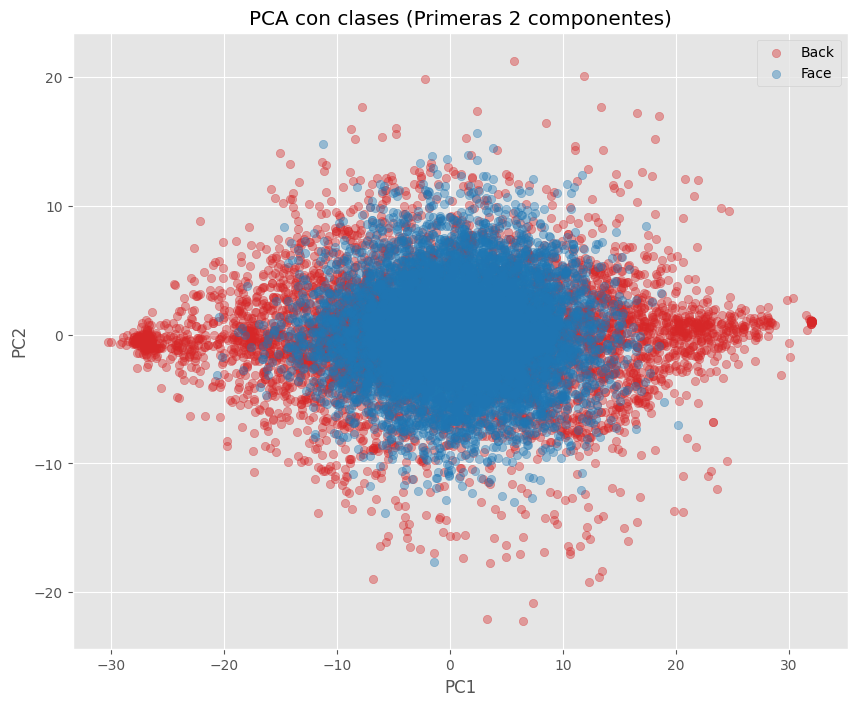

In [14]:
# Tomar solo las primeras dos componentes para graficar
X_plot = X_train_pca[:, :2]

# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

plt.figure(figsize=(10, 8))
for class_value in [0, 1]:
    plt.scatter(X_plot[y_train == class_value, 0], 
                X_plot[y_train == class_value, 1], 
                c=colors[class_value], 
                label=labels[class_value], 
                alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases (Primeras 2 componentes)')
plt.legend()
plt.grid(True)
plt.show()

# Models

In [15]:
# Separar en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(x_transform, y, test_size=0.2, random_state=42)

X_test_pca = pca.transform(X_test)

In [16]:
print(X_train_pca.shape)
print(X_test_pca.shape)
print(y_train.shape)
print(y_test.shape)

(17943, 200)
(7690, 200)
(17943,)
(7690,)


In [17]:
#Algorimtos de clasificacion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from re import A


In [18]:
X_train = X_train_pca

X_test = X_test_pca

## KNN

In [19]:
# Elegimos el k
k = 3

In [20]:
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [21]:
y_train_pred =knn.predict(X_train)
y_test_pred = knn.predict(X_test)

print('Accuracy train:',accuracy_score(y_train,y_train_pred))
print('Accuracy test: ',accuracy_score(y_test,y_test_pred))

Accuracy train: 0.9697375020899515
Accuracy test:  0.946814044213264


In [22]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      8990
         1.0       1.00      0.94      0.97      8953

    accuracy                           0.97     17943
   macro avg       0.97      0.97      0.97     17943
weighted avg       0.97      0.97      0.97     17943



In [23]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      3810
         1.0       0.99      0.90      0.94      3880

    accuracy                           0.95      7690
   macro avg       0.95      0.95      0.95      7690
weighted avg       0.95      0.95      0.95      7690



In [24]:
joblib.dump(knn, 'models/knn_model.joblib')

['models/knn_model.joblib']

### Implementar GridSearch para buscar la mejor k

In [25]:
from sklearn.model_selection import GridSearchCV

# 1. Definir el clasificador
knn = KNeighborsClassifier(metric='euclidean') 

# 2. Definir el rango de parámetros a buscar
param_grid = {
    'n_neighbors': list(range(1, 51, 2))
}

# Puedes ajustar este rango según tu problema y la cantidad de datos que tengas.
# Si tienes muchos datos, 'k' puede ser más grande.

# 3. Configurar GridSearchCV
# cv: número de folds para la validación cruzada (por ejemplo, 5 o 10)
# scoring: la métrica que se usará para evaluar los modelos (por ejemplo, 'accuracy')
# n_jobs: número de CPUs a usar (-1 significa usar todos los disponibles)
grid_search = GridSearchCV(estimator=knn,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1) # verbose=1 para ver el progreso

# 4. Ejecutar la búsqueda en cuadrícula en los datos de entrenamiento
print("Iniciando GridSearchCV...")
grid_search.fit(X_train, y_train)
print("GridSearchCV finalizado.")

# 5. Obtener los mejores resultados
print(f"Mejor parámetro 'k' (n_neighbors): {grid_search.best_params_['n_neighbors']}")
print(f"Mejor score (accuracy) en validación cruzada: {grid_search.best_score_:.4f}")

# 6. Evaluar el mejor modelo en el conjunto de prueba
best_knn = grid_search.best_estimator_

y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

print('\nResultados del mejor modelo:')
print('Accuracy train:', accuracy_score(y_train, y_train_pred))
print('Accuracy test: ', accuracy_score(y_test, y_test_pred))


Iniciando GridSearchCV...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
GridSearchCV finalizado.
Mejor parámetro 'k' (n_neighbors): 1
Mejor score (accuracy) en validación cruzada: 0.9518

Resultados del mejor modelo:
Accuracy train: 1.0
Accuracy test:  0.9540962288686606


In [26]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8990
         1.0       1.00      1.00      1.00      8953

    accuracy                           1.00     17943
   macro avg       1.00      1.00      1.00     17943
weighted avg       1.00      1.00      1.00     17943



In [27]:
joblib.dump(best_knn, 'models/best_knn_model.joblib')

['models/best_knn_model.joblib']

## Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

In [29]:
model = GaussianNB()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# print('Accuracy train:',accuracy_score(y_train,y_train_pred))
# print('Accuracy test: ',accuracy_score(y_test,y_test_pred))

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      8990
         1.0       0.94      0.93      0.94      8953

    accuracy                           0.94     17943
   macro avg       0.94      0.94      0.94     17943
weighted avg       0.94      0.94      0.94     17943



In [30]:
# X_test
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      3810
         1.0       0.93      0.94      0.94      3880

    accuracy                           0.93      7690
   macro avg       0.93      0.93      0.93      7690
weighted avg       0.93      0.93      0.93      7690



In [31]:
joblib.dump(model, 'models/nb_model.joblib')

['models/nb_model.joblib']

## Decision Tree

In [32]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [33]:
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      3810
         1.0       0.93      0.94      0.94      3880

    accuracy                           0.94      7690
   macro avg       0.94      0.94      0.94      7690
weighted avg       0.94      0.94      0.94      7690



In [34]:
joblib.dump(clf, 'models/tree_model.joblib')

['models/tree_model.joblib']